### failure-aware KE
Inspired by https://github.com/JohnDickerson/KidneyExchange.git

- Implemented:
    -  Model with Gurobi MIP Solver

- Ready to Work:
    - Branch-and-Price
    
- Not (going to be) Implemented:
    - InfiniteTailUtility 

#### imports

In [673]:
import json
import random
import networkx as nx
from typing import List, Tuple, Dict
from gurobi import *
import copy

#### utils

In [674]:
def _printLP(m):
    m.write('tmp.lp')
    f = open('tmp.lp', 'r')
    for l in f.readlines():
        print(l)
    print('====================')

#### Matching Pool Class

In [703]:
class Graph:
    def __init__(self, usingFailProb=True):
        self.g = nx.DiGraph()
        self.pairs = set()
        self.altruists = set()
        self.usingFailProb = usingFailProb
        
        
    def addV(self, vid:int, isPair=True):
        if isPair:
            self.pairs.add(vid)
            self.g.add_node(vid, Type='Pair')
        else:
            self.altruists.add(vid)
            self.g.add_node(vid, Type='Altruist')
            
            
    def addE(self, source:int, target:int, prob=1.0):
        self.g.add_edge(source, target, prob=prob)
    
    
    def saveAsFile(self, filename: str):
        pairs = list(self.pairs)
        altruists = list(self.altruists)
        
        edges = [[s,t,p] for s,t,p in self.g.edges.data('prob')]
        
        graphJson = json.dumps({"pairs": pairs, "altruists":altruists, "edges": edges})
        with open(filename, 'w') as f:
            f.write(graphJson)  
            
            
    def weighAnEdge(self, edge:Tuple[int, int]) -> float:
        return 1.0
    
    
    def weighDummyEdge(self, edge:Tuple[int, int]) -> float:
        return 1.0
    
    
    def failProbOfEdge(self, edge:Tuple[int, int]) -> float:
        return self.g.get_edge_data(edge[0], edge[1])['prob']


    def weighACycle(self, cycle:List[int]) -> float:
        startE = (cycle[0],cycle[1])
        pathWeight = 0
        pathSuccProb = 1
        pathWeight *= pathSuccProb
        for source, target in zip(cycle, cycle[1:]+[cycle[0]]):
            E = (source, target)
            pathWeight += self.weighAnEdge(E)
            pathSuccProb *= (1.0 - self.failProbOfEdge(E))

        if self.usingFailProb:
            return pathWeight * pathSuccProb
        else:
            return pathWeight
    

    def weighAChain(self, chain:List[int]) -> float:
        discountedPathWeight = 0.0
        rawPathWeight = 0
        pathSuccProb = 1
        
        for source, target in zip(chain[:-1], chain[1:]):
            E = (source, target)
            discountedPathWeight += rawPathWeight * pathSuccProb * self.failProbOfEdge(E)
            rawPathWeight += self.weighAnEdge(E)
            pathSuccProb *= (1 - self.failProbOfEdge(E))
            
            
        # DUMMY EDGE WEIGHT
        dummyEdgeWeight = self.weighDummyEdge((chain[-1], chain[0]))
        
        if self.usingFailProb:
#             print(discountedPathWeight, rawPathWeight , pathSuccProb)
            return discountedPathWeight + (rawPathWeight * pathSuccProb) + dummyEdgeWeight 
        else:
            return rawPathWeight + dummyEdgeWeight
            
    
    


#### Helper of Pool Class

In [715]:
def buildGraphFromRaw(pairs:List[int], altruists:List[int], 
                   edges_with_prob:List[Tuple[int, int, float]]) -> Graph:
    self = Graph()
    for v in pairs:
        self.addV(v, isPair=True)
    for v in altruists:
        self.addV(v, isPair=False)
    for s,t,p in edges_with_prob:
        self.addE(s, t, p)
    return self


def noDummy2withDummy(graph:Graph) -> Graph:
    newGraph = copy.deepcopy(graph)
    for nid in graph.pairs:
        for al in graph.altruists:
            newGraph.addE(nid, al, 1.0)
    return newGraph


def generateRandomGraph(N:int, M:int, with_dummy=True) -> Graph:
    pairs = [0, 1, 2, 3]
    altruists = [4, 5]
#     altruists = []
    
    prob = 0.7

    edges = set([(0, 1), (1, 2), (1, 3), (2, 1), (2, 0), (3, 2), (4, 3)])

    for nid in range(len(pairs)+len(altruists), N):
        pairs.append(nid)

    oldM = len(edges)
    for m in range(M - oldM):
        s = random.randint(0, N-1)
        t = random.randint(0, N-1)
        if t not in altruists:
            edges.add( (s, t) )

    edges_with_prob = [(s, t, prob) for s,t in edges]
    
    graph = buildGraphFromRaw(pairs, altruists, edges_with_prob)
    if with_dummy:
        return noDummy2withDummy(graph)
    else:
        return graph

    
    
def buildGraphFromFile(filename: str) -> Graph:
    self = Graph()
    with open(filename) as f:
        graph = json.load(f)
        pairs = graph["pairs"]
        altruists = graph["altruists"]
        edges_with_prob = list(map(tuple, graph["edges"]))
        
        return buildGraphFromRaw(pairs, altruists, edges_with_prob)


#### Cycle/Chain Generators

In [716]:

def genCyclesOfANode(graph: Graph, node: int, length:int, only_source=False) -> Tuple[List[List[int]], List[float]]:
    visited = set()
    def genNext(cur: int, rest: int) -> List[List[int]]:
        res = []
        visited.add(cur)
        if rest == 2:
            if node in graph.g.adj[cur]:
                res.append([cur])
        else:        
            for nxt in graph.g.adj[cur]:
                if only_source and nxt < node or nxt in visited or nxt in graph.altruists:
                    continue
                for r in genNext(nxt, rest-1):
                    r.append(cur)
                    res.append(r)
        visited.remove(cur)
        return res
    ans = [l[::-1] for l in genNext(node, length+1)]
    return ans, [graph.weighACycle(x) for x in ans]


def genChainsOfANode(graph: Graph, node: int, length: int) -> Tuple[List[List[int]], List[float]]:
    visited = set()
    def genNext(cur: int, rest:int) -> List[List[int]]:
        res = []
        visited.add(cur)
        if rest == 1:
            return [[cur]]
        else:
            for nxt in graph.g.adj[cur]:
                if nxt in visited or nxt in graph.altruists:
                    continue
                for r in genNext(nxt, rest-1):
                    r.append(cur)
                    res.append(r)
        visited.remove(cur)
        return res
    ans = [l[::-1] for l in genNext(node, length)]
    return ans, [graph.weighAChain(x) for x in ans]
                                            

    
def genAllCycles(graph: Graph, cycleCap: int) -> Tuple[List[List[int]], List[float]]:
    res1 = []
    res2 = []
    for pair in graph.pairs:
        for l in range(2, cycleCap+1):
            r, w = genCyclesOfANode(graph, pair, l, True)
            res1 += r
            res2 += w
    return res1, res2


def genAllChains(graph: Graph, chainCap: int) -> Tuple[List[List[int]], List[float]]:
    res1 = []
    res2 = []
    for altruist in graph.altruists:
        for l in range(2, chainCap+2):
            r, w = genChainsOfANode(graph, altruist, l)
            res1 += r
            res2 += w
    return res1, res2
        
        
def genAllCyclesAndChains(graph: Graph, cycleCap: int, chainCap: int) -> Tuple[List[List[int]], List[float]]:
    res1, res2 = genAllCycles(graph, cycleCap)
    r1, r2 = genAllChains(graph, chainCap) 
    res1 += r1
    res2 += r2
    return res1, res2





#### Gurobi MIP Solver

In [717]:
    
def mipSolve(graph: Graph,  cycleCap: int, chainCap: int):
    model = Model()
    model.setObjective(0, sense=GRB.MAXIMIZE)
#     c2var = {}
    
    varsOfRow = {}
    for n in graph.pairs:
        varsOfRow[n] = []
    for n in graph.altruists:
        varsOfRow[n] = []
    
    cycles, weights = genAllCycles(graph, cycleCap)
    for cycle, weight in zip(cycles, weights):
        vname = 'X_{}'.format(cycle)
        var = model.addVar(name=vname, obj=weight, vtype=GRB.BINARY)
#         c2var[tuple(cycle)] = var
        for n in cycle:
            varsOfRow[n].append(var)
        
    
    chains, weights = genAllChains(graph, chainCap)
    for chain, weight in zip(chains, weights):
        vname = 'Y_{}'.format(chain)
        var = model.addVar(name=vname, obj=weight, vtype=GRB.BINARY)
#         c2var[tuple(chain)] = var
        for n in chain:
            varsOfRow[n].append(var)
        
    model.update()
        
    for r in varsOfRow:
        model.addConstr( quicksum((var for var in varsOfRow[r])) <= 1, sense=GRB.LESS_EQUAL)
    
 
    model.optimize()
    return model
        

### Free Tests

In [718]:
N = 10
M = 10
fn = "./KidneyExchange-master/test_graph.json"

graph = generateRandomGraph(N, M, with_dummy=False)

In [692]:
graph = buildGraphFromRaw([0,1,2,3,5], [4, 6], 
                          [(0, 1, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (2, 5, 1.0), (3, 2, 1.0), (4, 2, 1.0), (6, 3, 1.0)])


In [681]:
graph = buildGraphFromRaw([0,1,2,3], [4], 
                          [(4, 1, 0.7), (1, 2, 0.7), (2, 3, 0.2), (2, 3, 1.0)])


In [719]:
graph.saveAsFile(fn)

In [720]:
graph = buildGraphFromFile(fn)

In [721]:
noDummy2withDummy(graph).saveAsFile(fn)

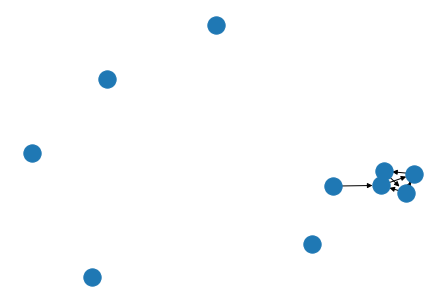

In [722]:
nx.draw(graph.g, pos=nx.spring_layout(graph.g), with_label=True)
# graph.g.add_edge(4, 9, prob=1.0)
# graph.g.edges()

In [723]:
# graph = Graph()
# graph.addV(0)
# graph.addV(1)
# graph.addV(2)
# graph.addV(3)
# graph.addV(4)
# graph.addV(5)
# edges = [(0,1), (1,2), (2,3), (2,0), (2,3), (3,0),
#          (3,4), (4,5), (5,0), (0,3), (3, 2), (0,2), (3, 1)]
# for s,t in edges:
#     graph.addE(s,t)
    
# genCycle(graph, 3, 3, False)


In [724]:
m = mipSolve(graph, 4, 3)

_printLP(m)
for v in m.getVars():
    print(v.varname, v.X)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 10 rows, 8 columns and 25 nonzeros
Model fingerprint: 0x1e65e948
Variable types: 0 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.3810000
Presolve removed 10 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 1.48 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.480000000000e+00, best bound 1.480000000000e+00, gap 0.0000%
\ LP format - for model browsing. Use MPS format to capture full model detail.

Maximize

  0.081 X_[0,_1,_2] + 0.0324 X_[0,_1,_3,_2] + 0.18 X_[1,_2]

   + 0.081 X_[1,_3,_2] + 1.3 Y_[4,_3] + 1.39 Y_[4,_3,_2]

   + 1.417 Y_[4,_3,_2,_1] + 1.417 Y_[4,_3

In [725]:
graph.usingFailProb = True
genAllCyclesAndChains(noDummy2withDummy(graph), cycleCap=4, chainCap=3)

([[0, 1, 2],
  [0, 1, 3, 2],
  [1, 2],
  [1, 3, 2],
  [4, 3],
  [4, 3, 2],
  [4, 3, 2, 1],
  [4, 3, 2, 0]],
 [0.08100000000000003,
  0.03240000000000002,
  0.18000000000000005,
  0.08100000000000003,
  1.3,
  1.3900000000000001,
  1.417,
  1.417])

In [712]:
g.get_edge_data(1, 0)['prob']

0.1

In [713]:
g.edges()

OutEdgeView([(1, 0), (2, 1)])

In [714]:
3*(0.3**3)

0.08099999999999999